# Experiments
## Bioit set - basic ARTM with regularizers

In [1]:
%matplotlib inline
import glob
import os
import matplotlib.pyplot as plt
import pandas as pd
import artm

In [2]:
artm.version()

'0.9.2'

In [ ]:
#Preparing input
input_folder = '../Data/bioit_set/'
batch_vectorizer = artm.BatchVectorizer(data_path=f'{input_folder}bioit_set_2_vw.txt',
                                        data_format='vowpal_wabbit',
                                        target_folder='my_collection_batches')
cooc_dict = artm.Dictionary()
cooc_dict.gather(
    data_path='batches_folder',
    cooc_file_path=f'{input_folder}cooc_2.txt',
    vocab_file_path=f'{input_folder}vocab_2.txt',
    symmetric_cooc_values=True)

In [ ]:
#defining regularizers
regularizers = [
    artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.15),
    artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.1),
    artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1.5e+5),
]

new_regularizers = [
    artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.15),
]
#hyperparameters
num_topics = 5
topic_names = ['topic_{}'.format(i) for i in range(num_topics)]

#defining quality metrics
scores = [
    artm.PerplexityScore(name='PerplexityScore', dictionary=batch_vectorizer.dictionary),
    artm.SparsityPhiScore(name='SparsityPhiScore'),
    artm.SparsityThetaScore(name='SparsityThetaScore'),
    artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.3),
    artm.TopTokensScore(name='TopTokensScore', num_tokens=10),
    artm.TopicKernelScore(
        class_id='@default_class',
        name='TopKernelScore Coherence', 
        dictionary=cooc_dict, 
        topic_names=topic_names)
         ]

#creating the model
model_artm = artm.ARTM(topic_names=topic_names, 
                       class_ids = {"@default_class": 1.0, "@bigram": 1.0},
                       cache_theta=True,
                       scores=scores,
                       regularizers=regularizers,
                        num_topics = num_topics)

#EM hyperparameters
num_collection_passes = 25
#varying regularization coefficients
model_artm.regularizers['SparsePhi'].tau = -0.2
model_artm.regularizers['SparseTheta'].tau = -20
# model_artm.regularizers['DecorrelatorPhi'].tau = 2.5e+5

In [ ]:
#Fitting the model
model_artm.initialize(dictionary = cooc_dict)
model_artm.fit_offline(
    batch_vectorizer=batch_vectorizer, 
    num_collection_passes=num_collection_passes)

In [ ]:
def print_measures(model:list):          
    print('Sparsity Phi: {0:.3f} '.format(
        model.score_tracker['SparsityPhiScore'].last_value))

    print('Sparsity Theta: {0:.3f}'.format(
        model.score_tracker['SparsityThetaScore'].last_value))

    print('Kernel contrast: {0:.3f}'.format(
        model.score_tracker['TopicKernelScore'].last_average_contrast))

    print('Kernel purity: {0:.3f}'.format(
        model.score_tracker['TopicKernelScore'].last_average_purity))
    
    plt.plot(range(len(model.score_tracker['SparsityPhiScore'].value)),
         model.score_tracker['SparsityPhiScore'].value, 'r--', linewidth=2)
    plt.title('Plot of Phi Sparsity Score by Iteration')
    plt.xlabel('Iterations count')
    plt.ylabel('Phi sparsity')
    plt.show()
    
    plt.plot(range(len(model.score_tracker['SparsityThetaScore'].value)),
             model.score_tracker['SparsityThetaScore'].value, 'r--', linewidth=2)
    plt.title('Plot of Theta Sparsity Score by Iteration')
    plt.xlabel('Iterations count')
    plt.ylabel('Theta sparsity')
    plt.show()
    if type(model) == artm.artm_model.ARTM:
        df = pd.DataFrame.from_dict(model.score_tracker['TopicKernelScore'].contrast).transpose()
#         plt.figure(figsize=(6, 6))
        df.boxplot()
        plt.xlabel('Iteration')
        plt.ylabel('Kernel contrast')
        plt.title('Boxplot of Kernel Contrast across topics by Iteration')
        plt.xticks(color='w')
        plt.show()

        df = pd.DataFrame.from_dict(model.score_tracker['TopicKernelScore'].purity).transpose()
#         plt.figure(figsize=(6, 6))
        df.boxplot()
        plt.xlabel('Iteration')
        plt.ylabel('Kernel purity')
        plt.title('Boxplot of Kernel Purity across topics by Iteration')
        plt.xticks(color='w')
        plt.show()

        df = pd.DataFrame.from_dict(model.score_tracker['TopKernelScore Coherence'].coherence).transpose()
#         plt.figure(figsize=(6, 6))
        df.boxplot()
        plt.xlabel('Iteration')
        plt.ylabel('Kernel coherence')
        plt.title('Boxplot of Kernel Coherence across topics by Iteration')
        plt.xticks(color='w')
        plt.show()
    elif type(model) == artm.hierarchy_utils.ARTM_Level:
        df = pd.DataFrame.from_dict(model._score_tracker['TopicKernelScore'].contrast).transpose()
#         plt.figure(figsize=(6, 6))
        df.boxplot()
        plt.xlabel('Iteration')
        plt.ylabel('Kernel contrast')
        plt.title('Boxplot of Kernel Contrast across topics by Iteration')
        plt.xticks(color='w')
        plt.show()

        df = pd.DataFrame.from_dict(model._score_tracker['TopicKernelScore'].purity).transpose()
#         plt.figure(figsize=(6, 6))
        df.boxplot()
        plt.xlabel('Iteration')
        plt.ylabel('Kernel purity')
        plt.title('Boxplot of Kernel Purity across topics by Iteration')
        plt.xticks(color='w')
        plt.show()

        df = pd.DataFrame.from_dict(model._score_tracker['TopKernelScore Coherence'].coherence).transpose()
#         plt.figure(figsize=(6, 6))
        df.boxplot()
        plt.xlabel('Iteration')
        plt.ylabel('Kernel coherence')
        plt.title('Boxplot of Kernel Coherence across topics by Iteration')
        plt.xticks(color='w')
        plt.show()

In [ ]:
print_measures(model_artm)

In [ ]:
for topic_name in model_artm.topic_names:
    print(
        topic_name + ': ', model_artm.score_tracker['TopTokensScore'].last_tokens[topic_name])

In [ ]:
print(model_artm.phi_)
print(model_artm.get_theta())

## NLP set - basic ARTM with regularizers

In [ ]:
#Preparing input
input_folder = '../Data/nlp_set/'
batch_vectorizer = artm.BatchVectorizer(data_path=f'{input_folder}nlp_set_2_vw.txt',
                                        data_format='vowpal_wabbit',
                                        target_folder='my_collection_batches')
cooc_dict = artm.Dictionary()
cooc_dict.gather(
    data_path='batches_folder',
    cooc_file_path=f'{input_folder}cooc_2.txt',
    vocab_file_path=f'{input_folder}vocab_2.txt',
    symmetric_cooc_values=True)


In [ ]:
#defining regularizers
regularizers = [
    artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.15),
    artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.1),
    artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1.5e+5),
]

new_regularizers = [
    artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.15),
]
#hyperparameters
num_topics = 5
topic_names = ['topic_{}'.format(i) for i in range(num_topics)]

#defining quality metrics
scores = [
    artm.PerplexityScore(name='PerplexityScore', dictionary=batch_vectorizer.dictionary),
    artm.SparsityPhiScore(name='SparsityPhiScore'),
    artm.SparsityThetaScore(name='SparsityThetaScore'),
    artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.3),
    artm.TopTokensScore(name='TopTokensScore', num_tokens=10),
    artm.TopicKernelScore(
        class_id='@default_class',
        name='TopKernelScore Coherence', 
        dictionary=cooc_dict, 
        topic_names=topic_names)
         ]

#creating the model
model_artm = artm.ARTM(
                       topic_names=topic_names, 
                       class_ids = {"@default_class": 1.0, "@bigram": 1.0},
                       cache_theta=True,
                       scores=scores,
                       regularizers=regularizers,
                        num_topics = num_topics)

#EM hyperparameters
num_collection_passes = 25
#varying regularization coefficients
model_artm.regularizers['SparsePhi'].tau = -0.2
model_artm.regularizers['SparseTheta'].tau = -20
# model_artm.regularizers['DecorrelatorPhi'].tau = 2.5e+5

In [ ]:
#Fitting the model
model_artm.initialize(dictionary = cooc_dict)
model_artm.fit_offline(
    batch_vectorizer=batch_vectorizer, 
    num_collection_passes=num_collection_passes)

In [ ]:
print_measures(model_artm)

In [ ]:
for topic_name in model_artm.topic_names:
    print(
        topic_name + ': ', model_artm.score_tracker['TopTokensScore'].last_tokens[topic_name])

In [ ]:
print(model_artm.phi_)
print(model_artm.get_theta())

# Hierarchical topic models

## NLP set - hARTM with regularizers

In [ ]:
#Preparing input
input_folder = '../Data/nlp_set/'
n_gram_value = 1
batch_vectorizer = artm.BatchVectorizer(data_path=f'{input_folder}nlp_set_{n_gram_value}_vw.txt',
                                        data_format='vowpal_wabbit',
                                        target_folder='my_collection_batches')
cooc_dict = artm.Dictionary()
cooc_dict.gather(
    data_path='batches_folder',
    cooc_file_path=f'{input_folder}cooc_{n_gram_value}.txt',
    vocab_file_path=f'{input_folder}vocab_{n_gram_value}.txt',
    symmetric_cooc_values=True)

In [ ]:
#Define regularizers
regularizers = [
    artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.15),
    artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.1),
    artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1.5e+5),
]

In [ ]:
#Define quality scores
scores = [
    artm.PerplexityScore(name='PerplexityScore', dictionary=batch_vectorizer.dictionary),
    artm.SparsityPhiScore(name='SparsityPhiScore'),
    artm.SparsityThetaScore(name='SparsityThetaScore'),
    artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.3),
    artm.TopTokensScore(name='TopTokensScore', num_tokens=10),
    artm.TopicKernelScore(
        class_id='@default_class',
        name='TopKernelScore Coherence', 
        dictionary=cooc_dict)
         ]

In [ ]:
#Define the model hierarchy
model_artm = artm.hARTM(
    regularizers = regularizers,
    scores=scores,
    cache_theta=True
)

In [ ]:
#Add root level
level1 = model_artm.add_level(
    num_topics=5,
    
)

In [ ]:
#Initialize
level1.initialize(dictionary = cooc_dict)
#Fit
level1.fit_offline(
    batch_vectorizer=batch_vectorizer, 
    num_collection_passes=1)

In [ ]:
#Add first level
level2 = model_artm.add_level(
    num_topics=10
)

In [ ]:
#Initialize
level2.initialize(dictionary = cooc_dict)
level2.fit_offline(
    batch_vectorizer=batch_vectorizer, 
    num_collection_passes=1)

In [ ]:
#Fit
model_artm.fit_offline(
    batch_vectorizer=batch_vectorizer, 
    num_collection_passes=25)

In [ ]:
print(model_artm.get_level(0).phi_)
print(model_artm.get_level(0).get_theta())

In [ ]:
#The way to access score tracker for hARTM models
for i in range(2)
    print_measures(model_artm.get_level(i))

## Bioit set - hARTM with regularizers

In [ ]:
#Preparing input
input_folder = '../Data/bioit_set/'
n_gram_value = 2
batch_vectorizer = artm.BatchVectorizer(data_path=f'{input_folder}bioit_set_{n_gram_value}_vw.txt',
                                        data_format='vowpal_wabbit',
                                        target_folder='my_collection_batches')
cooc_dict = artm.Dictionary()
cooc_dict.gather(
    data_path='batches_folder',
    cooc_file_path=f'{input_folder}cooc_{n_gram_value}.txt',
    vocab_file_path=f'{input_folder}vocab_{n_gram_value}.txt',
    symmetric_cooc_values=True)

In [ ]:
#Define regularizers
regularizers = [
    artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.15),
    artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.1),
    artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1.5e+5),
]

In [ ]:
#Define quality scores
scores = [
    artm.PerplexityScore(name='PerplexityScore', dictionary=batch_vectorizer.dictionary),
    artm.SparsityPhiScore(name='SparsityPhiScore'),
    artm.SparsityThetaScore(name='SparsityThetaScore'),
    artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.3),
    artm.TopTokensScore(name='TopTokensScore', num_tokens=10),
    artm.TopicKernelScore(
        class_id='@default_class',
        name='TopKernelScore Coherence', 
        dictionary=cooc_dict)
         ]

In [ ]:
#Define the model hierarchy
model_artm = artm.hARTM(
    regularizers = regularizers,
    scores=scores,
    cache_theta=True
)

In [ ]:
#Add root level
level1 = model_artm.add_level(
    num_topics=5,
    
)

In [ ]:
#Initialize
level1.initialize(dictionary = cooc_dict)

In [ ]:
#Add first level
level2 = model_artm.add_level(
    num_topics=10
)

In [ ]:
#Initialize
level2.initialize(dictionary = cooc_dict)

In [ ]:
#Fit
model_artm.fit_offline(
    batch_vectorizer=batch_vectorizer, 
    num_collection_passes=25)

In [ ]:
print(model_artm.get_level(0).phi_)
print(model_artm.get_level(0).get_theta())

In [ ]:
for topic_name in model_artm.get_level(0).topic_names:
    print(topic_name + ': ')
    print(model_artm.get_level(0)._score_tracker['TopTokensScore'].last_tokens[topic_name])

In [ ]:
for topic_name in model_artm.get_level(1).topic_names:
    print(topic_name + ': ')
    print(model_artm.get_level(1)._score_tracker['TopTokensScore'].last_tokens[topic_name])

In [ ]:
#The way to access score tracker for hARTM models
print_measures(model_artm.get_level(0))

# Note on iterative training process
- This training process will serve as basis to the subsequent development of the hierarchical model
- Coherence calculation requires co-occurence to be calculated prior to modeling
    - revisit preprocessing step
- Regularizers can be added using ```model.regularizers.add```
- Regularizers can not be removed, but can be "turned-off" by setting regularization coefficient value to 0
- The general training procedure is described by Khodorchenko et al., 2020 as follows:

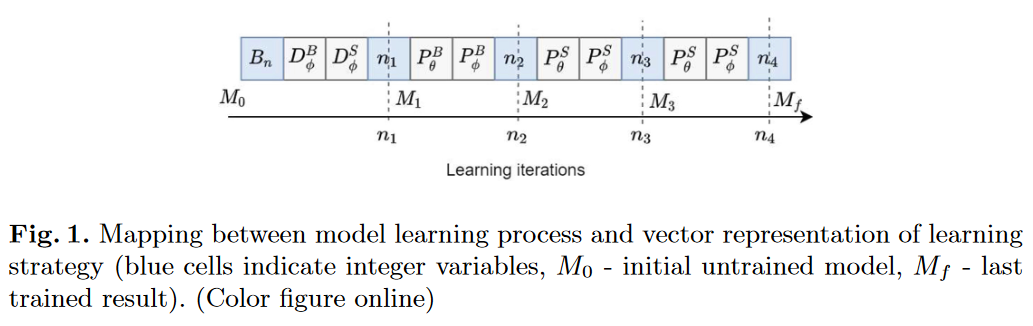

## Notation
    - B - initial number of topics
    - D - decorrelation regularizer
    - n - number of iterations
    - P - smoothing regularizers
        - B upper index - background topics
        - S upper index - specific topics
        - Phi - topics as token distributions
        - Theta - documents as topic distributions

## NLP set - iterative training

In [ ]:
#Preparing input
input_folder = '../Data/nlp_set/'
n_gram_value = 1
batch_vectorizer = artm.BatchVectorizer(data_path=f'{input_folder}nlp_set_{n_gram_value}_vw.txt',
                                        data_format='vowpal_wabbit',
                                        target_folder='my_collection_batches')
cooc_dict = artm.Dictionary()
cooc_dict.gather(
    data_path='batches_folder',
    cooc_file_path=f'{input_folder}cooc_{n_gram_value}.txt',
    vocab_file_path=f'{input_folder}vocab_{n_gram_value}.txt',
    symmetric_cooc_values=True)

In [ ]:
#background and specific topics
bg_topics = [f'topic_{i}' for i in range(2)]
sp_topics = [f'topic_{i}' for i in range(2,10)]

#defining regularizers
regularizers = [
    artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=0),
    artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=0),
    artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=2.5e+5)
]

new_regularizers = [
    artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.15),
]
#hyperparameters
num_topics = 10
topic_names = ['topic_{}'.format(i) for i in range(num_topics)]

#defining quality metrics
scores = [
    artm.PerplexityScore(name='PerplexityScore', dictionary=batch_vectorizer.dictionary),
    artm.SparsityPhiScore(name='SparsityPhiScore'),
    artm.SparsityThetaScore(name='SparsityThetaScore'),
    artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.3),
    artm.TopTokensScore(name='TopTokensScore', num_tokens=10),
    artm.TopicKernelScore(
        class_id='@default_class',
        name='TopKernelScore Coherence', 
        dictionary=cooc_dict, 
        topic_names=topic_names)
         ]

#creating the model
model_artm = artm.ARTM(topic_names=topic_names, 
                       class_ids = {"@default_class": 1.0, "@bigram": 1.0},
                       cache_theta=True,
                       scores=scores,
                       regularizers=regularizers,
                        num_topics = num_topics)

#EM hyperparameters
n1 = 25
#varying regularization coefficients
model_artm.regularizers['SparsePhi'].tau = -0.2
model_artm.regularizers['SparseTheta'].tau = -20

In [ ]:
#First training session
model_artm.initialize(dictionary = cooc_dict)
model_artm.fit_offline(
    batch_vectorizer=batch_vectorizer, 
    num_collection_passes=n1)

In [ ]:
#Altering regularizers
model_artm.regularizers['SparsePhi'].tau = 0.2
model_artm.regularizers['SparsePhi'].topic_names = bg_topics
model_artm.regularizers['SparseTheta'].tau = 0.2
model_artm.regularizers['SparseTheta'].topic_names = bg_topics
model_artm.regularizers['DecorrelatorPhi'].tau = 0
n2 = 10

In [ ]:
#First training session
model_artm.fit_offline(
    batch_vectorizer=batch_vectorizer, 
    num_collection_passes=n2)

In [ ]:
#Altering regularizers
model_artm.regularizers['SparsePhi'].tau = 0.5
model_artm.regularizers['SparsePhi'].topic_names = sp_topics
model_artm.regularizers['SparseTheta'].tau = 0.2
model_artm.regularizers['SparseTheta'].topic_names = sp_topics
model_artm.regularizers['DecorrelatorPhi'].tau = 0
n3 = 25

In [ ]:
#Second training session
model_artm.fit_offline(
    batch_vectorizer=batch_vectorizer, 
    num_collection_passes=n3)

In [ ]:
print_measures(model_artm)

In [ ]:
for topic_name in model_artm.topic_names:
    print(topic_name + ': ')
    print(model_artm.score_tracker['TopTokensScore'].last_tokens[topic_name])

## BIOIT set - iterative training

In [ ]:
#Preparing input
input_folder = '../Data/bioit_set/'
n_gram_value = 1
batch_vectorizer = artm.BatchVectorizer(data_path=f'{input_folder}bioit_set_{n_gram_value}_vw.txt',
                                        data_format='vowpal_wabbit',
                                        target_folder='my_collection_batches')
cooc_dict = artm.Dictionary()
cooc_dict.gather(
    data_path='batches_folder',
    cooc_file_path=f'{input_folder}cooc_{n_gram_value}.txt',
    vocab_file_path=f'{input_folder}vocab_{n_gram_value}.txt',
    symmetric_cooc_values=True)

In [ ]:
#background and specific topics
bg_topics = [f'topic_{i}' for i in range(2)]
sp_topics = [f'topic_{i}' for i in range(2,10)]

#defining regularizers
regularizers = [
    artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=0),
    artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=0),
    artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=2.5e+5)
]

new_regularizers = [
    artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.15),
]
#hyperparameters
num_topics = 10
topic_names = ['topic_{}'.format(i) for i in range(num_topics)]

#defining quality metrics
scores = [
    artm.PerplexityScore(name='PerplexityScore', dictionary=batch_vectorizer.dictionary),
    artm.SparsityPhiScore(name='SparsityPhiScore'),
    artm.SparsityThetaScore(name='SparsityThetaScore'),
    artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.3),
    artm.TopTokensScore(name='TopTokensScore', num_tokens=10),
    artm.TopicKernelScore(
        class_id='@default_class',
        name='TopKernelScore Coherence', 
        dictionary=cooc_dict, 
        topic_names=topic_names)
         ]

#creating the model
model_artm = artm.ARTM(topic_names=topic_names, 
                       class_ids = {"@default_class": 1.0, "@bigram": 1.0},
                       cache_theta=True,
                       scores=scores,
                       regularizers=regularizers,
                        num_topics = num_topics)

#EM hyperparameters
n1 = 25
#varying regularization coefficients
model_artm.regularizers['SparsePhi'].tau = -0.2
model_artm.regularizers['SparseTheta'].tau = -20

In [ ]:
#First training session
model_artm.initialize(dictionary = cooc_dict)
model_artm.fit_offline(
    batch_vectorizer=batch_vectorizer, 
    num_collection_passes=n1)

In [ ]:
#Altering regularizers
model_artm.regularizers['SparsePhi'].tau = 0.2
model_artm.regularizers['SparsePhi'].topic_names = bg_topics
model_artm.regularizers['SparseTheta'].tau = 0.2
model_artm.regularizers['SparseTheta'].topic_names = bg_topics
model_artm.regularizers['DecorrelatorPhi'].tau = 0
n2 = 10

In [ ]:
#First training session
model_artm.fit_offline(
    batch_vectorizer=batch_vectorizer, 
    num_collection_passes=n2)

In [ ]:
#Altering regularizers
model_artm.regularizers['SparsePhi'].tau = 0.5
model_artm.regularizers['SparsePhi'].topic_names = sp_topics
model_artm.regularizers['SparseTheta'].tau = 0.2
model_artm.regularizers['SparseTheta'].topic_names = sp_topics
model_artm.regularizers['DecorrelatorPhi'].tau = 0
n3 = 25

In [ ]:
#Second training session
model_artm.fit_offline(
    batch_vectorizer=batch_vectorizer, 
    num_collection_passes=n3)

In [ ]:
print_measures(model_artm)

In [ ]:
for topic_name in model_artm.topic_names:
    print(topic_name + ': ')
    print(model_artm.score_tracker['TopTokensScore'].last_tokens[topic_name])

# Iterative training with hARTM

## NLP set

In [ ]:
#Preparing input
input_folder = '../Data/nlp_set/'
n_gram_value = 1
batch_vectorizer = artm.BatchVectorizer(data_path=f'{input_folder}nlp_set_{n_gram_value}_vw.txt',
                                        data_format='vowpal_wabbit',
                                        target_folder='my_collection_batches')
cooc_dict = artm.Dictionary()
cooc_dict.gather(
    data_path='batches_folder',
    cooc_file_path=f'{input_folder}cooc_{n_gram_value}.txt',
    vocab_file_path=f'{input_folder}vocab_{n_gram_value}.txt',
    symmetric_cooc_values=True)

In [ ]:
#Define regularizers
regularizers = [
    artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=0),
    artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=0),
    artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1.5e+5),
]

In [ ]:
#Define quality scores
scores = [
    artm.PerplexityScore(name='PerplexityScore', dictionary=batch_vectorizer.dictionary),
    artm.SparsityPhiScore(name='SparsityPhiScore'),
    artm.SparsityThetaScore(name='SparsityThetaScore'),
    artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.3),
    artm.TopTokensScore(name='TopTokensScore', num_tokens=10),
    artm.TopicKernelScore(
        class_id='@default_class',
        name='TopKernelScore Coherence', 
        dictionary=cooc_dict)
         ]

In [ ]:
#background and specific topics
bg_topics = [f'topic_{i}' for i in range(2)]
sp_topics = [f'topic_{i}' for i in range(2,10)]

In [ ]:
#Define the model hierarchy
model_artm = artm.hARTM(
    regularizers = regularizers,
    scores=scores,
    cache_theta=True
)

In [ ]:
#Add root level
level1 = model_artm.add_level(
    num_topics=5,
    
)

In [ ]:
#Initialize
level1.initialize(dictionary = cooc_dict)

In [ ]:
#Add first level
level2 = model_artm.add_level(
    num_topics=10
)

In [ ]:
#Initialize
level2.initialize(dictionary = cooc_dict)

In [ ]:
#Fit
n1 = 10
model_artm.fit_offline(
    batch_vectorizer=batch_vectorizer, 
    num_collection_passes=n1)

In [ ]:
#Altering regularizers
model_artm.get_level(0).regularizers['SparsePhi'].tau = 0.2
model_artm.get_level(0).regularizers['SparsePhi'].topic_names = bg_topics
model_artm.get_level(0).regularizers['SparseTheta'].tau = 0.2
model_artm.get_level(0).regularizers['SparseTheta'].topic_names = bg_topics
model_artm.get_level(0).regularizers['DecorrelatorPhi'].tau = 0
n2 = 10

In [ ]:
#Fit
model_artm.fit_offline(
    batch_vectorizer=batch_vectorizer, 
    num_collection_passes=n2)

In [ ]:
print_measures(level1)

In [ ]:
for topic_name in model_artm.get_level(0).topic_names:
    print(topic_name + ': ')
    print(model_artm.get_level(0)._score_tracker['TopTokensScore'].last_tokens[topic_name])

In [ ]:
print_measures(level2)

In [ ]:
for topic_name in model_artm.get_level(1).topic_names:
    print(topic_name + ': ')
    print(model_artm.get_level(1)._score_tracker['TopTokensScore'].last_tokens[topic_name])

# Genetic algorithm for parameter optimization
- as suggested by Khodorchenko et al., 2020

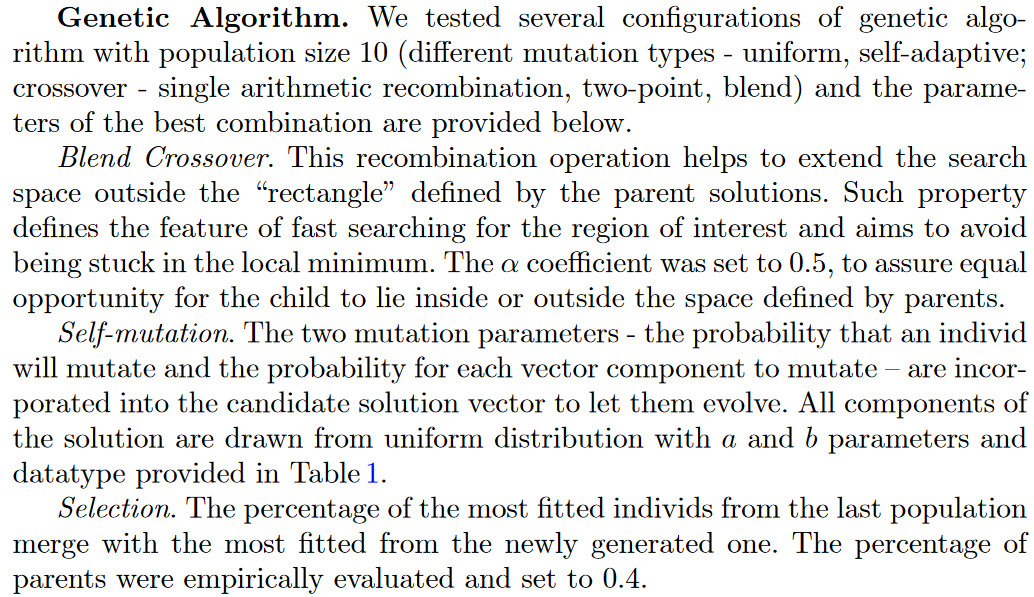

# Suggested hyperparameter boundaries for optimization

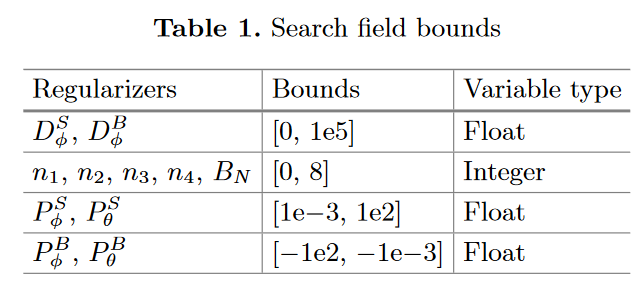

## Notation
    - B - initial number of topics
    - D - decorrelation regularizer
    - n - number of iterations
    - P - smoothing regularizers
        - B upper index - background topics
        - S upper index - specific topics
        - Phi - topics as token distributions
        - Theta - documents as topic distributions

- The GA implementation in Python is possible using the following tool:
 - https://pygad.readthedocs.io/en/latest/
 - https://pygad.readthedocs.io/en/latest/pygad_more.html#multi-objective-optimization
 - Renyi entropy should be tested for hierarchical model as proposed in https://doi.org/10.7717/peerj-cs.608.
    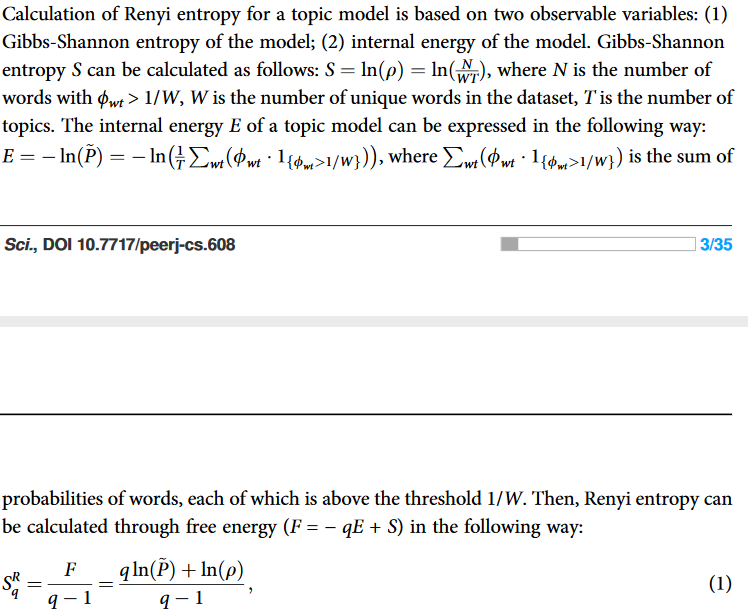

- Tutorial:
https://pablormier.github.io/2017/09/05/a-tutorial-on-differential-evolution-with-python/
- Additionally bayesian optimization could be implemented using the following algorithm:
https://github.com/bayesian-optimization/BayesianOptimization

- Fitness function for flat model based on kernel coherence:
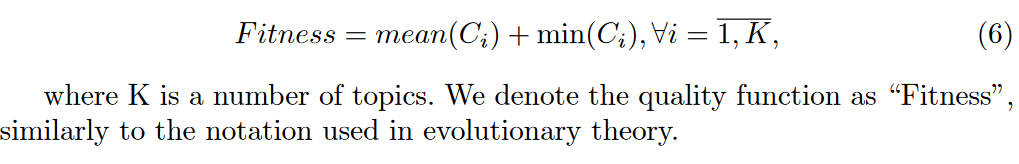

# Composing wrappers
- Model training should be repeatable as the resulting model parameters are inputs required to calculate the fitness function values.
- The same input data should be used each time
- Model structure in terms of regularizers and number of training sessions is fixed
- Parameters
    - regularization coefficients (float)
    - number of iterations in each training session (int)
    - number of background topics (int)
    - number of specific topics (int)

In [ ]:
#Preparing input
input_folder = '../Data/nlp_set/'
n_gram_value = 1
batch_vectorizer = artm.BatchVectorizer(data_path=f'{input_folder}nlp_set_{n_gram_value}_vw.txt',
                                        data_format='vowpal_wabbit',
                                        target_folder='my_collection_batches')
cooc_dict = artm.Dictionary()
cooc_dict.gather(
    data_path='batches_folder',
    cooc_file_path=f'{input_folder}cooc_{n_gram_value}.txt',
    vocab_file_path=f'{input_folder}vocab_{n_gram_value}.txt',
    symmetric_cooc_values=True)

In [ ]:
#Number of topics
num_topics = 10
topic_names = ['topic_{}'.format(i) for i in range(num_topics)]
num_bg_topics = 2

#defining regularizers
regularizer_names = [
    'SparsePhi',
    'SparseTheta',
    'DecorrelatorPhi',
]
regularizers = [
    artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=0),
    artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=0),
    artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=2.5e+5)
]
tau_dict_1 = dict(zip(regularizer_names, [0,0,2.5e+5]))
n1 = 10

#defining quality metrics
scores = [
    artm.PerplexityScore(name='PerplexityScore', dictionary=batch_vectorizer.dictionary),
    artm.SparsityPhiScore(name='SparsityPhiScore'),
    artm.SparsityThetaScore(name='SparsityThetaScore'),
    artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.3),
    artm.TopTokensScore(name='TopTokensScore', num_tokens=10),
    artm.TopicKernelScore(
        class_id='@default_class',
        name='TopKernelScore Coherence', 
        dictionary=cooc_dict, 
        topic_names=topic_names)
         ]

#Altering regularizers
tau_dict_2 = dict(zip(regularizer_names, [0.5,0.2,0]))
n2 = 10

#Altering regularizers
tau_dict_3 = dict(zip(regularizer_names, [0.5,0.2,0]))
n3 = 25

#Altering regularizers
tau_dict_4 = dict(zip(regularizer_names, [0.5,0.2,0]))
n4 = 25

In [ ]:
def train_flat_tm(
    batch_vectorizer:artm.BatchVectorizer,
    dictionary:artm.Dictionary, 
    scores:list,
    num_topics:int, 
    num_bg_topics:list,
    regularizers:list,
    n1:int,
    tau_dict_1:dict,
    n2:int,
    tau_dict_2:dict,
    n3:int,
    tau_dict_3:dict,
    n4:int,
    tau_dict_4:dict,
    topic_names:list = ['topic_{}'.format(i) for i in range(num_topics)],
) -> (artm.ARTM, list):
    '''Train the flat unimodal topic model using the algorithm suggested by M. Khodorchenko et al.'''
    
    #background and specific topics
    bg_topics = [f'topic_{i}' for i in range(num_bg_topics)]
    sp_topics = [f'topic_{i}' for i in range(num_bg_topics,num_topics)]
    
    
    #creating the model
    model_artm = artm.ARTM(
        topic_names  = topic_names, 
        class_ids    = {"@default_class": 1.0, "@bigram": 1.0},
        cache_theta  = True,
        scores       = scores,
        regularizers = regularizers,
        num_topics   = num_topics)
    
    #Altering regularizers for 2nd training session
    model_artm.regularizers['SparsePhi'].tau           = tau_dict_1['SparsePhi']
    model_artm.regularizers['SparseTheta'].tau         = tau_dict_1['SparseTheta']
    model_artm.regularizers['DecorrelatorPhi'].tau     = tau_dict_1['DecorrelatorPhi']
    
    #initializing the model from dictionary
    model_artm.initialize(dictionary = cooc_dict)
    
    #First training session
    model_artm.fit_offline(
        batch_vectorizer      = batch_vectorizer, 
        num_collection_passes = n1)
    
    #Altering regularizers for 2nd training session
    model_artm.regularizers['SparsePhi'].tau           = tau_dict_2['SparsePhi']
    model_artm.regularizers['SparsePhi'].topic_names   = bg_topics
    model_artm.regularizers['SparseTheta'].tau         = tau_dict_2['SparseTheta']
    model_artm.regularizers['SparseTheta'].topic_names = bg_topics
    model_artm.regularizers['DecorrelatorPhi'].tau     = tau_dict_2['DecorrelatorPhi']
    
    #Second training session
    model_artm.fit_offline(
        batch_vectorizer      = batch_vectorizer, 
        num_collection_passes = n2)
    
    #Altering regularizers
    model_artm.regularizers['SparsePhi'].tau           = tau_dict_3['SparsePhi']
    model_artm.regularizers['SparsePhi'].topic_names   = sp_topics
    model_artm.regularizers['SparseTheta'].tau         = tau_dict_3['SparseTheta']
    model_artm.regularizers['SparseTheta'].topic_names = sp_topics
    model_artm.regularizers['DecorrelatorPhi'].tau     = tau_dict_3['DecorrelatorPhi']
    
    #Third training session
    model_artm.fit_offline(
        batch_vectorizer      = batch_vectorizer, 
        num_collection_passes = n3)

    #Altering regularizers
    model_artm.regularizers['SparsePhi'].tau       = tau_dict_4['SparsePhi']
    model_artm.regularizers['SparseTheta'].tau     = tau_dict_4['SparseTheta']
    model_artm.regularizers['DecorrelatorPhi'].tau = tau_dict_4['DecorrelatorPhi']
    
    #Fourth training session
    model_artm.fit_offline(
        batch_vectorizer      = batch_vectorizer, 
        num_collection_passes = n3)
    
    #Parameter preservation
    min_fcoherence = min(model_artm.score_tracker['TopKernelScore Coherence'].coherence[-1].values())
    mean_fcoherence = model_artm.score_tracker['TopKernelScore Coherence'].average_coherence[-1]
    parameters = {
        'n':[n1,n2,n3,n4],
        'num_bg':[num_bg_topics],
        'num_topics':[num_topics],
        'SparsePhi'       : [
            tau_dict_1['SparsePhi'],
            tau_dict_2['SparsePhi'],
            tau_dict_3['SparsePhi'],
            tau_dict_4['SparsePhi']
        ],
        'SparseTheta'     : [
            tau_dict_1['SparseTheta'],
            tau_dict_2['SparseTheta'],
            tau_dict_3['SparseTheta'],
            tau_dict_4['SparseTheta']
        ],
        'DecorrelatorPhi' : [
            tau_dict_1['DecorrelatorPhi'],
            tau_dict_2['DecorrelatorPhi'],
            tau_dict_3['DecorrelatorPhi'],
            tau_dict_4['DecorrelatorPhi']
        ] 
    }
    fitness = min_fcoherence + mean_fcoherence
    flat_params = sum(list(parameters.values()),[])
    return model_artm, flat_params, fitness

In [ ]:
model, parameters, score = train_flat_tm(
    batch_vectorizer = batch_vectorizer,
    dictionary = cooc_dict, 
    scores = scores,
    num_topics = num_topics, 
    topic_names = topic_names,
    num_bg_topics = num_bg_topics,
    regularizers = regularizers,
    n1 = n1,
    tau_dict_1 = tau_dict_1,
    n2 = n2,
    tau_dict_2 = tau_dict_2,
    n3 = n3,
    tau_dict_3 = tau_dict_3,
    n4 = n4,
    tau_dict_4 = tau_dict_4,
)

In [ ]:
score

# Trying optimization with genetic algorithm

In [ ]:
import pygad
import numpy as np

def decode_solution(solution):
    # The first 6 genes are integers
    integer_params = [int(gene) for gene in solution[:6]]
    
    # The remaining genes are floating-point numbers for regularization coefficients
    float_params = solution[6:]
    
    # Assuming the order of parameters in the chromosome matches their order in the train_flat_tm function
    # Unpack integer_params for readability (adjust according to your parameter structure)
    n1, n2, n3, n4, num_bg_topics,num_topics = integer_params
    
    # Return the unpacked parameters
    # float_params are returned as is, assuming train_flat_tm expects them as a list or similar structure
    return n1, n2, n3, n4, num_bg_topics,num_topics, float_params


def fitness_function(ga_instance, solution, solution_idx):
    n1, n2, n3, n4, num_bg_topics, num_topics, float_params = decode_solution(solution)
    
    # Assuming train_flat_tm and other required variables (like batch_vectorizer, cooc_dict, etc.) are defined elsewhere
    model, parameters, score = train_flat_tm(
        batch_vectorizer=batch_vectorizer,
        dictionary=cooc_dict,
        scores=scores,
        num_topics=num_topics,
        topic_names=topic_names,
        num_bg_topics = num_bg_topics,
        regularizers=regularizers,
        n1=n1,
        tau_dict_1=dict(zip(regularizer_names, [float_params[i] for i in [0, 3, 8]])),
        n2=n2,
        tau_dict_2=dict(zip(regularizer_names, [float_params[i] for i in [1, 4, 9]])),
        n3=n3,
        tau_dict_3=dict(zip(regularizer_names, [float_params[i] for i in [2, 5, 10]])),
        n4=n4,
        tau_dict_4=dict(zip(regularizer_names, [float_params[i] for i in [3, 6, 11]]))
    )
    return score

In [ ]:
#Defining constraints on parameter values
int_gene_space = [{'low': 0, 'high': 8}]*6
float_gene_space = [
    {'low': 0, 'high': 0},
    {'low': -0.01, 'high': -0.001},
    {'low': 0.001, 'high': 1e2},
    {'low': 0.001, 'high': 1e2},
    {'low': -0.01, 'high': -0.001},
    {'low': -0.01, 'high': -0.001},
    {'low': 0.001, 'high': 1e2},
    {'low': 0.001, 'high': 1e2},
    {'low': 0.0, 'high': 1e5},
    {'low': 0.0, 'high': 1e5},
    {'low': 0.0, 'high': 1e5},
    {'low': 0.0, 'high': 1e5},
]
gene_space = int_gene_space + float_gene_space

In [ ]:
def on_generation(ga_instance):
    current_generation = ga_instance.generations_completed
    best_solution, best_solution_fitness, best_solution_idx = ga_instance.best_solution()
    print(f"Generation {current_generation}: Best Fitness = {best_solution_fitness}")


In [ ]:
ga_instance = pygad.GA(
    num_generations=1,
    num_parents_mating=10,
    fitness_func=fitness_function,
    sol_per_pop=20,
    num_genes=18,  # 6 integer + 12 float parameters
    gene_space=gene_space,
    parent_selection_type="rank",
    crossover_type="single_point",
    mutation_type="random",
    mutation_percent_genes=10,
    allow_duplicate_genes=False,
    on_generation=on_generation,
)

In [ ]:
%%time
ga_instance.run()

In [ ]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print(f"Best Solution: {solution}, Fitness: {solution_fitness}")

In [ ]:
model, parameters, score = train_flat_tm(
        batch_vectorizer=batch_vectorizer,
        dictionary=cooc_dict,
        scores=scores,
        num_topics=int(solution[4]),
        topic_names=topic_names,
        num_bg_topics = int(solution[5]),
        regularizers=regularizers,
        n1=int(solution[0]),
        tau_dict_1=dict(zip(regularizer_names, [solution[6:][i] for i in [0, 3, 8]])),
        n2=int(solution[1]),
        tau_dict_2=dict(zip(regularizer_names, [solution[6:][i] for i in [1, 4, 9]])),
        n3=int(solution[2]),
        tau_dict_3=dict(zip(regularizer_names, [solution[6:][i] for i in [2, 5, 10]])),
        n4=int(solution[3]),
        tau_dict_4=dict(zip(regularizer_names, [solution[6:][i] for i in [3, 6, 11]]))
    )

In [ ]:
print_measures(model)

# Attempting to use Renyi entropy to figure out optimal number of topics in each layer (need to implement optimization over number of topics)

### Renyi entropy calculation

In [ ]:
# import numpy as np

# level_1_phi = model.get_level(0).get_phi()
# l1phi_np = level_1_phi.to_numpy()

# W = int(str(cooc_dict).split(" ")[-1][:-1].split("=")[-1])

# T = topics_per_level[0]


# p_uniform = 1/W
# phi_non_uniform = l1phi_np[l1phi_np > p_uniform]
# N = len(phi_non_uniform)

# S = np.log(N/(W*T))

# E = -np.log((1/T)*np.sum(phi_non_uniform))

# q = 1/T

# S_qR = (-q*E+S)/(q-1)

# S_qR

In [3]:
def get_renyi_entropy(model, dictionary, num_topics):
    '''Function to calculate renyi entropy for topic model
    based on  https://doi.org/10.7717/peerj-cs.608'''
    import numpy as np
    #Getting token distribution for each topic
    phi = model.get_phi()
    phi_np = phi.to_numpy()
    
    #Getting number of words in the dictionary
    W = int(str(dictionary).split(" ")[-1][:-1].split("=")[-1])
    
    #Calculating uniform distribution threshold value
    p_uniform = 1/W
    
    #Filtering the phi_wt matrix based on threshold
    phi_gt_uniform = phi_np[phi_np > p_uniform]
    
    #Getting number of entries above threshold
    N = len(phi_gt_uniform)
    
    #Getting number of topics in the model
    T = num_topics
    
    #Calculating Gibbs-Shannon entropy
    S = np.log(N/(W*T))
    
    #Calculating internal energy
    E = -np.log((1/T)*np.sum(phi_gt_uniform))
    
    #Calculating deformation parameter
    q = 1/T
    
    #Calculating Renyi entropy value
    S_qR = (-q*E+S)/(q-1)
    return S_qR

In [ ]:
# get_renyi_entropy(model.get_level(0), cooc_dict, topics_per_level[0])

### Model wrapper and training

In [ ]:
#Preparing input
input_folder = '../Data/nlp_set/'
n_gram_value = 1
batch_vectorizer = artm.BatchVectorizer(data_path=f'{input_folder}nlp_set_{n_gram_value}_vw.txt',
                                        data_format='vowpal_wabbit',
                                        target_folder='my_collection_batches')
cooc_dict = artm.Dictionary()
cooc_dict.gather(
    data_path='batches_folder',
    cooc_file_path=f'{input_folder}cooc_{n_gram_value}.txt',
    vocab_file_path=f'{input_folder}vocab_{n_gram_value}.txt',
    symmetric_cooc_values=True)

In [ ]:
#Number of topics
num_levels = 4
topics_per_level = [2, 4, 8, 16] #should be increasing with index

#defining regularizers
regularizer_names = [
    'SparsePhi',
    'SparseTheta',
    'DecorrelatorPhi',
]
regularizers = [
    artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=0),
    artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=0),
    artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=2.5e+5),
    artm.HierarchySparsingThetaRegularizer(name='Hierarchy', tau=0),
    artm.TopicSelectionThetaRegularizer(name='TopicDecorr',tau=0)
]
tau_dict_1 = dict(zip(regularizer_names, [0,0,2.5e+5]))
n1 = 10

#defining quality metrics
scores = [
    artm.PerplexityScore(name='PerplexityScore', dictionary=batch_vectorizer.dictionary),
    artm.SparsityPhiScore(name='SparsityPhiScore'),
    artm.SparsityThetaScore(name='SparsityThetaScore'),
    artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.3),
    artm.TopTokensScore(name='TopTokensScore', num_tokens=10),
    artm.TopicKernelScore(
        class_id='@default_class',
        name='TopKernelScore Coherence', 
        dictionary=cooc_dict)
         ]

#Altering regularizers
tau_dict_2 = dict(zip(regularizer_names, [0.5,0.2,0]))
n2 = 10

#Altering regularizers
tau_dict_3 = dict(zip(regularizer_names, [0.5,0.2,0]))
n3 = 10

#Altering regularizers
tau_dict_4 = dict(zip(regularizer_names, [0.5,0.2,0]))
n4 = 10

In [4]:
import numpy as np
def train_hier_tm(
    batch_vectorizer:artm.BatchVectorizer,
    dictionary:artm.Dictionary, 
    scores:list,
    regularizers:list,
#     num_topics:int, 
#     num_bg_topics:list,
    num_levels:int,
    topics_per_level:list,
    n1:int,
    tau_dict_1:dict,
    n2:int,
    tau_dict_2:dict,
    n3:int,
    tau_dict_3:dict,
    n4:int,
    tau_dict_4:dict,
#     topic_names:list = ['topic_{}'.format(i) for i in range(num_topics)],
) -> (artm.ARTM, list):
    '''Train the flat unimodal topic model using the algorithm suggested by M. Khodorchenko et al.'''
    
    #background and specific topics
#     bg_topics = [f'topic_{i}' for i in range(num_bg_topics)]
#     sp_topics = [f'topic_{i}' for i in range(num_bg_topics,num_topics)]
    
    
    #creating the model
    model_artm = artm.hARTM(
        regularizers = regularizers,
        scores=scores,
        cache_theta=True
    )
    
    
    #Adding multiple levels to the model
    level_dict = {}
    for i in range(num_levels):
        level_id = f'level_{i}'
        #Add level
        level_dict[level_id] = model_artm.add_level(
            num_topics=topics_per_level[i],
            parent_level_weight = 0.5
        )

        #Initialize
        level_dict[level_id].initialize(dictionary = cooc_dict)
        level_dict[level_id].fit_offline(
            batch_vectorizer      = batch_vectorizer, 
            num_collection_passes = 1)
        
    
    #Altering regularizers for 2nd training session
    model_artm.get_level(0).regularizers['SparsePhi'].tau           = tau_dict_1['SparsePhi']
    model_artm.get_level(0).regularizers['SparseTheta'].tau         = tau_dict_1['SparseTheta']
    model_artm.get_level(0).regularizers['DecorrelatorPhi'].tau     = tau_dict_1['DecorrelatorPhi']
    
    #First training session
    model_artm.fit_offline(
        batch_vectorizer      = batch_vectorizer, 
        num_collection_passes = n1)
    
    #Altering regularizers for 2nd training session
    model_artm.get_level(0).regularizers['SparsePhi'].tau           = tau_dict_2['SparsePhi']
    model_artm.get_level(0).regularizers['SparseTheta'].tau         = tau_dict_2['SparseTheta']
    model_artm.get_level(0).regularizers['DecorrelatorPhi'].tau     = tau_dict_2['DecorrelatorPhi']
    
    #Second training session
    model_artm.fit_offline(
        batch_vectorizer      = batch_vectorizer, 
        num_collection_passes = n2)
    
    #Altering regularizers
    model_artm.get_level(0).regularizers['SparsePhi'].tau           = tau_dict_3['SparsePhi']
    model_artm.get_level(0).regularizers['SparseTheta'].tau         = tau_dict_3['SparseTheta']
    model_artm.get_level(0).regularizers['DecorrelatorPhi'].tau     = tau_dict_3['DecorrelatorPhi']
    
    #Third training session
    model_artm.fit_offline(
        batch_vectorizer      = batch_vectorizer, 
        num_collection_passes = n3)

    #Altering regularizers
    model_artm.get_level(0).regularizers['SparsePhi'].tau       = tau_dict_4['SparsePhi']
    model_artm.get_level(0).regularizers['SparseTheta'].tau     = tau_dict_4['SparseTheta']
    model_artm.get_level(0).regularizers['DecorrelatorPhi'].tau = tau_dict_4['DecorrelatorPhi']
    
    #Fourth training session
    model_artm.fit_offline(
        batch_vectorizer      = batch_vectorizer, 
        num_collection_passes = n3)
    
    #Calculating Renyi entropy for each level
    S_qR_dict = {}
    mean_S_qR = 0
    for i in range(num_levels):
        level_id = f'level_{i}'
        level = level_dict[level_id]
        S_qR = get_renyi_entropy(
            model=level, 
            dictionary=dictionary,
            num_topics=topics_per_level[i]
        )
        S_qR_dict[f'{level_id}'] = S_qR
        #Average Renyi entropy accross levels to use in score calculation
        mean_S_qR += S_qR/num_levels
    
    #Parameter preservation
    parameters = {
#         'n':[n1,n2,n3,n4],
#         'num_bg':[num_bg_topics],
#         'num_topics':[num_topics],
#         'topics_per_level':topics_per_level,
        'SparsePhi'       : [
            tau_dict_1['SparsePhi'],
            tau_dict_2['SparsePhi'],
            tau_dict_3['SparsePhi'],
            tau_dict_4['SparsePhi']
        ],
        'SparseTheta'     : [
            tau_dict_1['SparseTheta'],
            tau_dict_2['SparseTheta'],
            tau_dict_3['SparseTheta'],
            tau_dict_4['SparseTheta']
        ],
        'DecorrelatorPhi' : [
            tau_dict_1['DecorrelatorPhi'],
            tau_dict_2['DecorrelatorPhi'],
            tau_dict_3['DecorrelatorPhi'],
            tau_dict_4['DecorrelatorPhi']
        ],
    }
    
    #Generating parameter list
    flat_params = sum(list(parameters.values()),[])    
    
    #Calculating score for the whole model
    min_fc_list = []
    mean_fc_list = []
    for i in range(num_levels):
        min_fc_list.append(min(model_artm.get_level(i)._score_tracker['TopKernelScore Coherence'].coherence[-1].values()))
        mean_fc_list.append(model_artm.get_level(0)._score_tracker['TopKernelScore Coherence'].average_coherence[-1])
    min_fcoherence = np.array(min_fc_list)
    mean_fcoherence = np.array(mean_fc_list)
    fitness = np.mean(min_fcoherence + mean_fcoherence)
        
    return model_artm, flat_params, fitness, parameters, mean_S_qR

In [ ]:
%%time
model, flat_parameters, score, parameters, mean_S_qR = train_hier_tm(
    batch_vectorizer = batch_vectorizer,
    dictionary = cooc_dict, 
    scores = scores,
    regularizers = regularizers,
    num_levels=num_levels,
    topics_per_level=topics_per_level,
    n1 = n1,
    tau_dict_1 = tau_dict_1,
    n2 = n2,
    tau_dict_2 = tau_dict_2,
    n3 = n3,
    tau_dict_3 = tau_dict_3,
    n4 = n4,
    tau_dict_4 = tau_dict_4,
)

In [ ]:
score

In [ ]:
mean_S_qR

In [ ]:
flat_parameters

In [ ]:
parameters

In [ ]:
for i in range(num_levels):
    print(f'level{i}')
    for topic_name in model.get_level(i).topic_names:
        print(
            topic_name + ': ', model.get_level(i).score_tracker['TopTokensScore'].last_tokens[topic_name])

In [ ]:
#getting document embeddings for a given level
model.get_level(3).get_theta()

In [ ]:
#getting topic embeddings for parent level
model.get_level(3).get_psi()

In [ ]:
#getting topic-term distributions
model.get_level(3).get_phi()

### hARTM with bioit set

In [ ]:
#Preparing input
input_folder = '../Data/bioit_set/'
n_gram_value = 1
batch_vectorizer = artm.BatchVectorizer(data_path=f'{input_folder}bioit_set_{n_gram_value}_vw.txt',
                                        data_format='vowpal_wabbit',
                                        target_folder='my_collection_batches')
cooc_dict = artm.Dictionary()
cooc_dict.gather(
    data_path='batches_folder',
    cooc_file_path=f'{input_folder}cooc_{n_gram_value}.txt',
    vocab_file_path=f'{input_folder}vocab_{n_gram_value}.txt',
    symmetric_cooc_values=True)

In [ ]:
#Number of topics
num_levels = 4
topics_per_level = [2, 4, 8, 16] #should be increasing with index

#defining regularizers
regularizer_names = [
    'SparsePhi',
    'SparseTheta',
    'DecorrelatorPhi',
]
regularizers = [
    artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=0),
    artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=0),
    artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=2.5e+5),
    artm.HierarchySparsingThetaRegularizer(name='Hierarchy', tau=0),
    artm.TopicSelectionThetaRegularizer(name='TopicDecorr',tau=0)
]
tau_dict_1 = dict(zip(regularizer_names, [0,0,2.5e+5]))
n1 = 10

#defining quality metrics
scores = [
    artm.PerplexityScore(name='PerplexityScore', dictionary=batch_vectorizer.dictionary),
    artm.SparsityPhiScore(name='SparsityPhiScore'),
    artm.SparsityThetaScore(name='SparsityThetaScore'),
    artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.3),
    artm.TopTokensScore(name='TopTokensScore', num_tokens=10),
    artm.TopicKernelScore(
        class_id='@default_class',
        name='TopKernelScore Coherence', 
        dictionary=cooc_dict)
         ]

#Altering regularizers
tau_dict_2 = dict(zip(regularizer_names, [0.5,0.2,0]))
n2 = 10

#Altering regularizers
tau_dict_3 = dict(zip(regularizer_names, [0.5,0.2,0]))
n3 = 10

#Altering regularizers
tau_dict_4 = dict(zip(regularizer_names, [0.5,0.2,0]))
n4 = 10

In [ ]:
%%time
model, flat_parameters, score, parameters, mean_S_qR = train_hier_tm(
    batch_vectorizer = batch_vectorizer,
    dictionary = cooc_dict, 
    scores = scores,
    regularizers = regularizers,
    num_levels=num_levels,
    topics_per_level=topics_per_level,
    n1 = n1,
    tau_dict_1 = tau_dict_1,
    n2 = n2,
    tau_dict_2 = tau_dict_2,
    n3 = n3,
    tau_dict_3 = tau_dict_3,
    n4 = n4,
    tau_dict_4 = tau_dict_4,
)

In [ ]:
score

In [ ]:
mean_S_qR

In [ ]:
flat_parameters

In [ ]:
parameters

In [ ]:
for i in range(num_levels):
    print(f'level{i}')
    for topic_name in model.get_level(i).topic_names:
        print(
            topic_name + ': ', model.get_level(i).score_tracker['TopTokensScore'].last_tokens[topic_name])

In [ ]:
print_measures(model.get_level(0))

# Attempt to optimize the number of topics in each layer and the coefficients for regularizers in different iterations of Genetic Algorithm (as if they do no depend on each-other).

### First session - optimizing regularization coefficients

In [ ]:
#Defining constraints on parameter values
# int_gene_space = [{'low': 5, 'high': 10}]*num_levels
# float_gene_space = [
#     {'low': 0, 'high': 0},
#     {'low': -0.01, 'high': -0.001},
#     {'low': 0.001, 'high': 1e2},
#     {'low': 0.001, 'high': 1e2},
#     {'low': -0.01, 'high': -0.001},
#     {'low': -0.01, 'high': -0.001},
#     {'low': 0.001, 'high': 1e2},
#     {'low': 0.001, 'high': 1e2},
#     {'low': 0.0, 'high': 1e5},
#     {'low': 0.0, 'high': 1e5},
#     {'low': 0.0, 'high': 1e5},
#     {'low': 0.0, 'high': 1e5},
# ]
# gene_space = float_gene_space

In [ ]:
# import pygad
# import numpy as np

# def decode_solution(solution):
#     # The first 6 genes are integers
# #     integer_params = [int(gene) for gene in solution[:4]]
    
#     # Assuming the order of parameters in the chromosome matches their order in the train_flat_tm function
#     # Unpack integer_params for readability (adjust according to your parameter structure)
# #     n1, n2, n3, n4 = integer_params
    
    
#     #Number of topics per level
# #     nt_per_level = []
# #     for i in range(num_levels):
# #         nt_per_level.append(int(solution[i]))
    
#     # The remaining genes are floating-point numbers for regularization coefficients
#     float_params = solution #[num_levels:]
    
#     # Return the unpacked parameters
#     # float_params are returned as is, assuming train_flat_tm expects them as a list or similar structure
#     return  float_params #, n1, n2, n3, n4, nt_per_level


# def fitness_function(ga_instance, solution, solution_idx):
#     float_params = decode_solution(solution) # n1, n2, n3, n4, topics_per_level
    
#     model, flat_parameters, score, parameters = train_hier_tm(
#         batch_vectorizer = batch_vectorizer,
#         dictionary = cooc_dict, 
#         scores = scores, 
#         regularizers = regularizers,
#         num_levels=num_levels,
#         topics_per_level=topics_per_level,
#         n1=n1,
#         tau_dict_1=dict(zip(regularizer_names, [float_params[i] for i in [0, 3, 8]])),
#         n2=n2,
#         tau_dict_2=dict(zip(regularizer_names, [float_params[i] for i in [1, 4, 9]])),
#         n3=n3,
#         tau_dict_3=dict(zip(regularizer_names, [float_params[i] for i in [2, 5, 10]])),
#         n4=n4,
#         tau_dict_4=dict(zip(regularizer_names, [float_params[i] for i in [3, 6, 11]]))
#     )
#     return score

In [ ]:
# def on_generation(ga_instance):
#     current_generation = ga_instance.generations_completed
#     best_solution, best_solution_fitness, best_solution_idx = ga_instance.best_solution()
#     print(f"Generation {current_generation}: Best Fitness = {best_solution_fitness}")


In [ ]:
# ga_instance = pygad.GA(
#     num_generations=1,
#     num_parents_mating=10,
#     fitness_func=fitness_function,
#     sol_per_pop=20,
#     num_genes=12,  # 6 integer + 12 float parameters +num_levels
#     gene_space=gene_space,
#     parent_selection_type="rank",
#     crossover_type="single_point",
#     mutation_type="random",
#     mutation_percent_genes=10,
#     allow_duplicate_genes=False,
#     on_generation=on_generation,
# )

In [ ]:
# %%time
# ga_instance.run()

In [ ]:
# solution, solution_fitness, solution_idx = ga_instance.best_solution()
# print(f"Best Solution: {solution}, Fitness: {solution_fitness}")

### Second session - optimizing number of topics per layer coefficients

# Attemp to apply spectral clustering using document and topic embeddings from hierarchical model

In [5]:
#Preparing input
input_folder = '../Data/bioit_set/'
n_gram_value = 1
batch_vectorizer = artm.BatchVectorizer(data_path=f'{input_folder}bioit_set_{n_gram_value}_vw.txt',
                                        data_format='vowpal_wabbit',
                                        target_folder='my_collection_batches')
cooc_dict = artm.Dictionary()
cooc_dict.gather(
    data_path='batches_folder',
    cooc_file_path=f'{input_folder}cooc_{n_gram_value}.txt',
    vocab_file_path=f'{input_folder}vocab_{n_gram_value}.txt',
    symmetric_cooc_values=True)

In [6]:
#Number of topics
num_levels = 4
topics_per_level = [2, 4, 8, 16] #should be increasing with index

#defining regularizers
regularizer_names = [
    'SparsePhi',
    'SparseTheta',
    'DecorrelatorPhi',
]
regularizers = [
    artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=0),
    artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=0),
    artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=2.5e+5),
    artm.HierarchySparsingThetaRegularizer(name='Hierarchy', tau=0),
    artm.TopicSelectionThetaRegularizer(name='TopicDecorr',tau=0)
]
tau_dict_1 = dict(zip(regularizer_names, [0,0,2.5e+5]))
n1 = 10

#defining quality metrics
scores = [
    artm.PerplexityScore(name='PerplexityScore', dictionary=batch_vectorizer.dictionary),
    artm.SparsityPhiScore(name='SparsityPhiScore'),
    artm.SparsityThetaScore(name='SparsityThetaScore'),
    artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.3),
    artm.TopTokensScore(name='TopTokensScore', num_tokens=10),
    artm.TopicKernelScore(
        class_id='@default_class',
        name='TopKernelScore Coherence', 
        dictionary=cooc_dict)
         ]

#Altering regularizers
tau_dict_2 = dict(zip(regularizer_names, [0.5,0.2,0]))
n2 = 10

#Altering regularizers
tau_dict_3 = dict(zip(regularizer_names, [0.5,0.2,0]))
n3 = 10

#Altering regularizers
tau_dict_4 = dict(zip(regularizer_names, [0.5,0.2,0]))
n4 = 10

In [7]:
%%time
model, flat_parameters, score, parameters, mean_S_qR = train_hier_tm(
    batch_vectorizer = batch_vectorizer,
    dictionary = cooc_dict, 
    scores = scores,
    regularizers = regularizers,
    num_levels=num_levels,
    topics_per_level=topics_per_level,
    n1 = n1,
    tau_dict_1 = tau_dict_1,
    n2 = n2,
    tau_dict_2 = tau_dict_2,
    n3 = n3,
    tau_dict_3 = tau_dict_3,
    n4 = n4,
    tau_dict_4 = tau_dict_4,
)

CPU times: user 19.3 s, sys: 3.97 s, total: 23.3 s
Wall time: 14.4 s


In [8]:
def hellinger_distance(p, q):
    # Ensure the vectors are numpy arrays and normalized to sum to 1
    p = np.array(p) / np.sum(p)
    q = np.array(q) / np.sum(q)
    # Calculate the Hellinger distance
    distance = np.sqrt(np.sum((np.sqrt(p) - np.sqrt(q)) ** 2)) / np.sqrt(2)
    return distance

In [9]:
def get_distance_matrix(model, level_id):
    '''Calculates pairwise Hellinger distances from combined theta and psi matrices'''
    
    if level_id == 0:
        theta_psi = model.get_level(level_id).get_theta()
    else:
        #getting document embeddings for a given level
        theta = model.get_level(level_id).get_theta()

        #getting topic embeddings for parent level
        psi = model.get_level(level_id).get_psi()
        #Including embeddings for parent topics with documents
        theta_psi = theta.join(psi)

    #Distance matrix between documents using hellinger distance
    hlg_matrix = np.zeros((len(theta_psi.columns), len(theta_psi.columns)))
    for i, col1 in enumerate(theta_psi.columns):
        for j, col2 in enumerate(theta_psi.columns):
            hlg_matrix[i, j] = hellinger_distance(theta_psi[col1].values, theta_psi[col2].values)
    hlg_df = pd.DataFrame(hlg_matrix, columns=theta_psi.columns, index=theta_psi.columns)
    return hlg_df

In [10]:
def get_spectral_clusters(distance_matrix, num_topics):
    from sklearn.cluster import SpectralClustering

    # Convert the distance matrix to a similarity matrix
    similarity_matrix = similarity_matrix = 1 - distance_matrix.to_numpy()**2

    # Apply spectral clustering
    clustering = SpectralClustering(n_clusters = num_topics, affinity='precomputed', assign_labels='kmeans', random_state=42)
    labels = clustering.fit_predict(similarity_matrix)

    # 'labels' now contains the cluster assignments for each point
    return labels

In [11]:
def plot_clustering_results(dm, labels):
    from sklearn.manifold import MDS
    import matplotlib.pyplot as plt

    # Assuming 'distance_matrix' is your precomputed distance matrix and 'labels' are the clustering labels
    mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
    data_transformed = mds.fit_transform(dm.to_numpy())

    # 'data_transformed' is now a 2D representation of your original data

    # Create a scatter plot of the 2D projection
    unique_labels = np.unique(labels)
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))

    for label, color in zip(unique_labels, colors):
        idx = labels == label
        plt.scatter(data_transformed[idx, 0], data_transformed[idx, 1], c=[color], label=f"Cluster {label}", edgecolor='k', s=50, alpha=0.7)

    plt.title('Spectral Clustering Results with MDS')
    plt.xlabel('MDS1')
    plt.ylabel('MDS2')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()

In [27]:
def plot_clustering_results(dm, labels, threshold, level_id, n_components=2):
    from sklearn.manifold import MDS
    import matplotlib.pyplot as plt
    import numpy as np

    # Initialize MDS with the specified number of components (2D or 3D)
    mds = MDS(n_components=n_components, dissimilarity='precomputed', random_state=42)
    topic_names = dm.columns
    data_transformed = mds.fit_transform(dm.to_numpy())

    # Create a plot based on the number of components
    fig = plt.figure()
    if n_components == 3:
        from mpl_toolkits.mplot3d import Axes3D
        ax = fig.add_subplot(111, projection='3d')
        plot_func = ax.scatter
    else:
        ax = fig.add_subplot(111)
        plot_func = ax.scatter

    # Configure color map
    unique_labels = np.unique(labels)
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))

    # Plot each cluster
    for label, color in zip(unique_labels, colors):
        idx = np.where(labels == label)[0]  # Indices of points in the current cluster
        if n_components == 3:
            plot_func(data_transformed[idx, 0], data_transformed[idx, 1], data_transformed[idx, 2], c=[color], label=f"Cluster {label}", edgecolor='k', s=50, alpha=0.7)
        else:
            plot_func(data_transformed[idx, 0], data_transformed[idx, 1], c=[color], label=f"Cluster {label}", edgecolor='k', s=50, alpha=0.7)

        # Annotate each point in the cluster
        for point in idx:
            text = topic_names[point] if 'topic' not in str(topic_names[point]) else f'{topic_names[point]}_{level_id-1}'
            if n_components == 3:
                ax.text(data_transformed[point, 0], data_transformed[point, 1], data_transformed[point, 2], text, fontsize=9)
            else:
                plt.annotate(text,
                             (data_transformed[point, 0], data_transformed[point, 1]),
                             textcoords="offset points",
                             xytext=(5,2),
                             ha='center',
                             fontsize=9)

    # Draw connections for distances below the threshold
    for i in range(len(data_transformed)):
        for j in range(i + 1, len(data_transformed)):
            if dm.iloc[i, j] < threshold:
                if n_components == 3:
                    ax.plot([data_transformed[i, 0], data_transformed[j, 0]],
                            [data_transformed[i, 1], data_transformed[j, 1]],
                            [data_transformed[i, 2], data_transformed[j, 2]], 'k-', alpha=0.1)
                else:
                    plt.plot([data_transformed[i, 0], data_transformed[j, 0]],
                             [data_transformed[i, 1], data_transformed[j, 1]], 'k-', alpha=0.1)

    plt.title(f'Spectral Clustering Results with MDS, level {level_id}')
    if n_components == 2:
        plt.xlabel('MDS1')
        plt.ylabel('MDS2')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.subplots_adjust(right=0.75) if n_components == 2 else None
    plt.show()

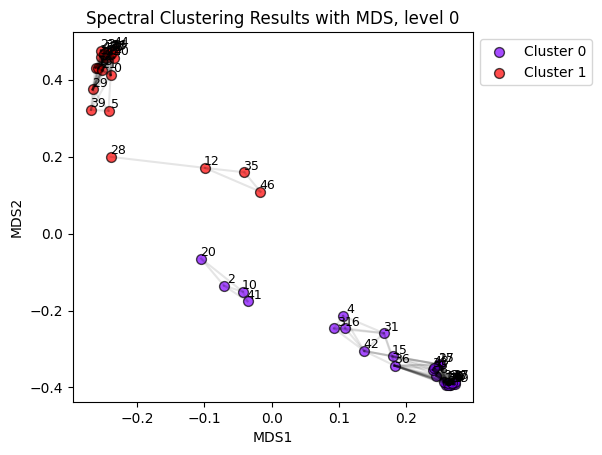

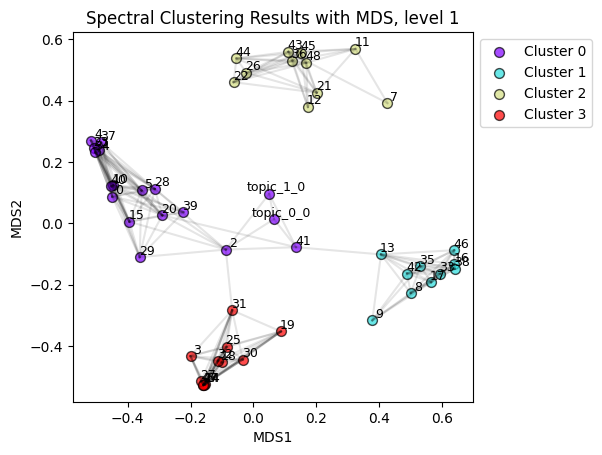

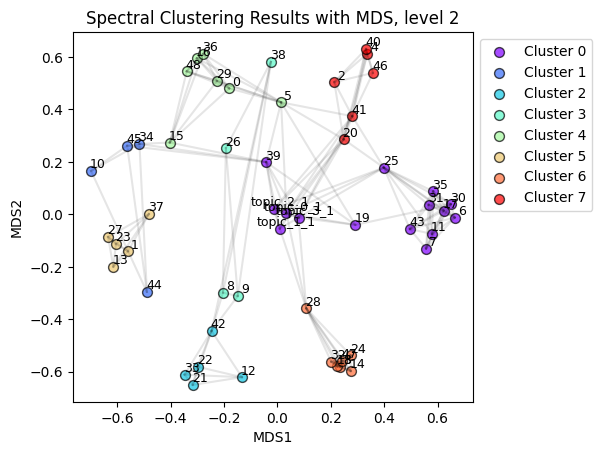

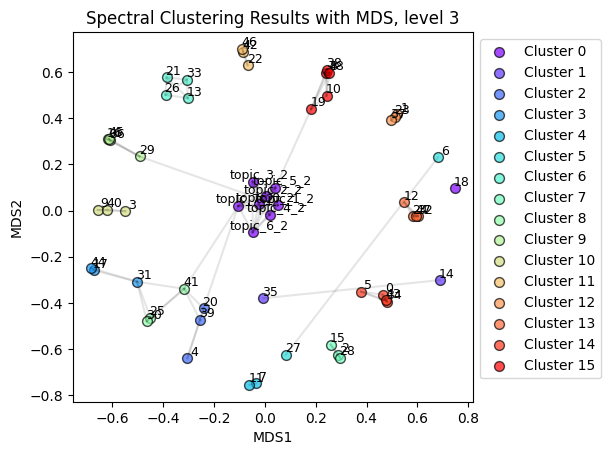

In [29]:
for level_id in range(num_levels):
    dm = get_distance_matrix(model, level_id)
    labels = get_spectral_clusters(dm,topics_per_level[level_id])
    threshold = np.mean(dm.to_numpy()) - np.std(dm.to_numpy())
    plot_clustering_results(dm, labels, threshold, level_id)

### Continue with plotting topic hierarchy

In [30]:
matrix_list = []
for level_id in range(1,num_levels):
    df = model.get_level(level_id).get_psi()
    df.columns = [f'{c}_{level_id-1}' for c in df.columns]
    df.index = [f'{c}_{level_id}' for c in df.index]
    matrix_list.append(df)

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

def plot_hierarchical_connections(dfs, threshold=0.15, spacing = 25, image_width=15):
    G = nx.Graph()
    pos = {}
    layer_y = 0  # Y position for the first layer
    y_offset = -5  # Vertical offset for subsequent layers
    
    # Determine the total number of layers for positioning
    total_layers = len(dfs) + 1  # +1 to include the 0th layer explicitly

    # Image width for centering
    half_width = image_width / 2

    # Process the first dataframe separately
    first_df = dfs[0]
    columns = first_df.columns
    indices = first_df.index

    # Position columns of the first dataframe
    for i, col in enumerate(columns):        
        # Calculate positions
        current_x_positions = half_width - (len(columns) / 2 - i) * spacing
        pos[col] = (current_x_positions, layer_y)
        
    #Adding spacing between the first and 2nd layer
    layer_y += y_offset
    
    # Position indices of the first dataframe as the second layer
    for i, index in enumerate(indices):
        current_x_positions = half_width - (len(indices) / 2 - i) * spacing
        pos[index] = (current_x_positions, layer_y)
    

    # Add edges for the first dataframe based on threshold
    for col in columns:
        for index in indices:
            if first_df.at[index, col] > threshold:
                G.add_edge(col, index)
                
    # Setting index of the first df as columns of the 2nd df
    columns = first_df.index
                
    # For subsequent dataframes, treat indices as the new layer connected to the previous layer's indices
    for df in dfs[1:]:
        new_layer_y = layer_y + y_offset
        new_indices = df.index
        
        
        # Position new indices
        for i, index in enumerate(new_indices):
            new_x_positions = half_width - (len(new_indices) / 2 - i) * spacing
            pos[index] = (new_x_positions, new_layer_y)
        
        # Add edges based on threshold, connecting previous indices to new indices
        for col in columns:  # Previous layer's indices now act as "columns"
            for index in new_indices:
                if df.at[index, col] > threshold:
                    G.add_edge(col, index)
        
        # Update for the next iteration
        layer_y = new_layer_y
        columns = new_indices  # The current indices become "columns" for the next layer

    # Draw the graph
    plt.figure(figsize=(image_width, 3 * total_layers))
    nx.draw(G, pos, with_labels=True, node_size=1000, node_color="skyblue", font_size=10, edge_color='k')
#     plt.title("Hierarchical Structure")
    plt.axis('off')  # Turn off the axis for clarity
    plt.show()


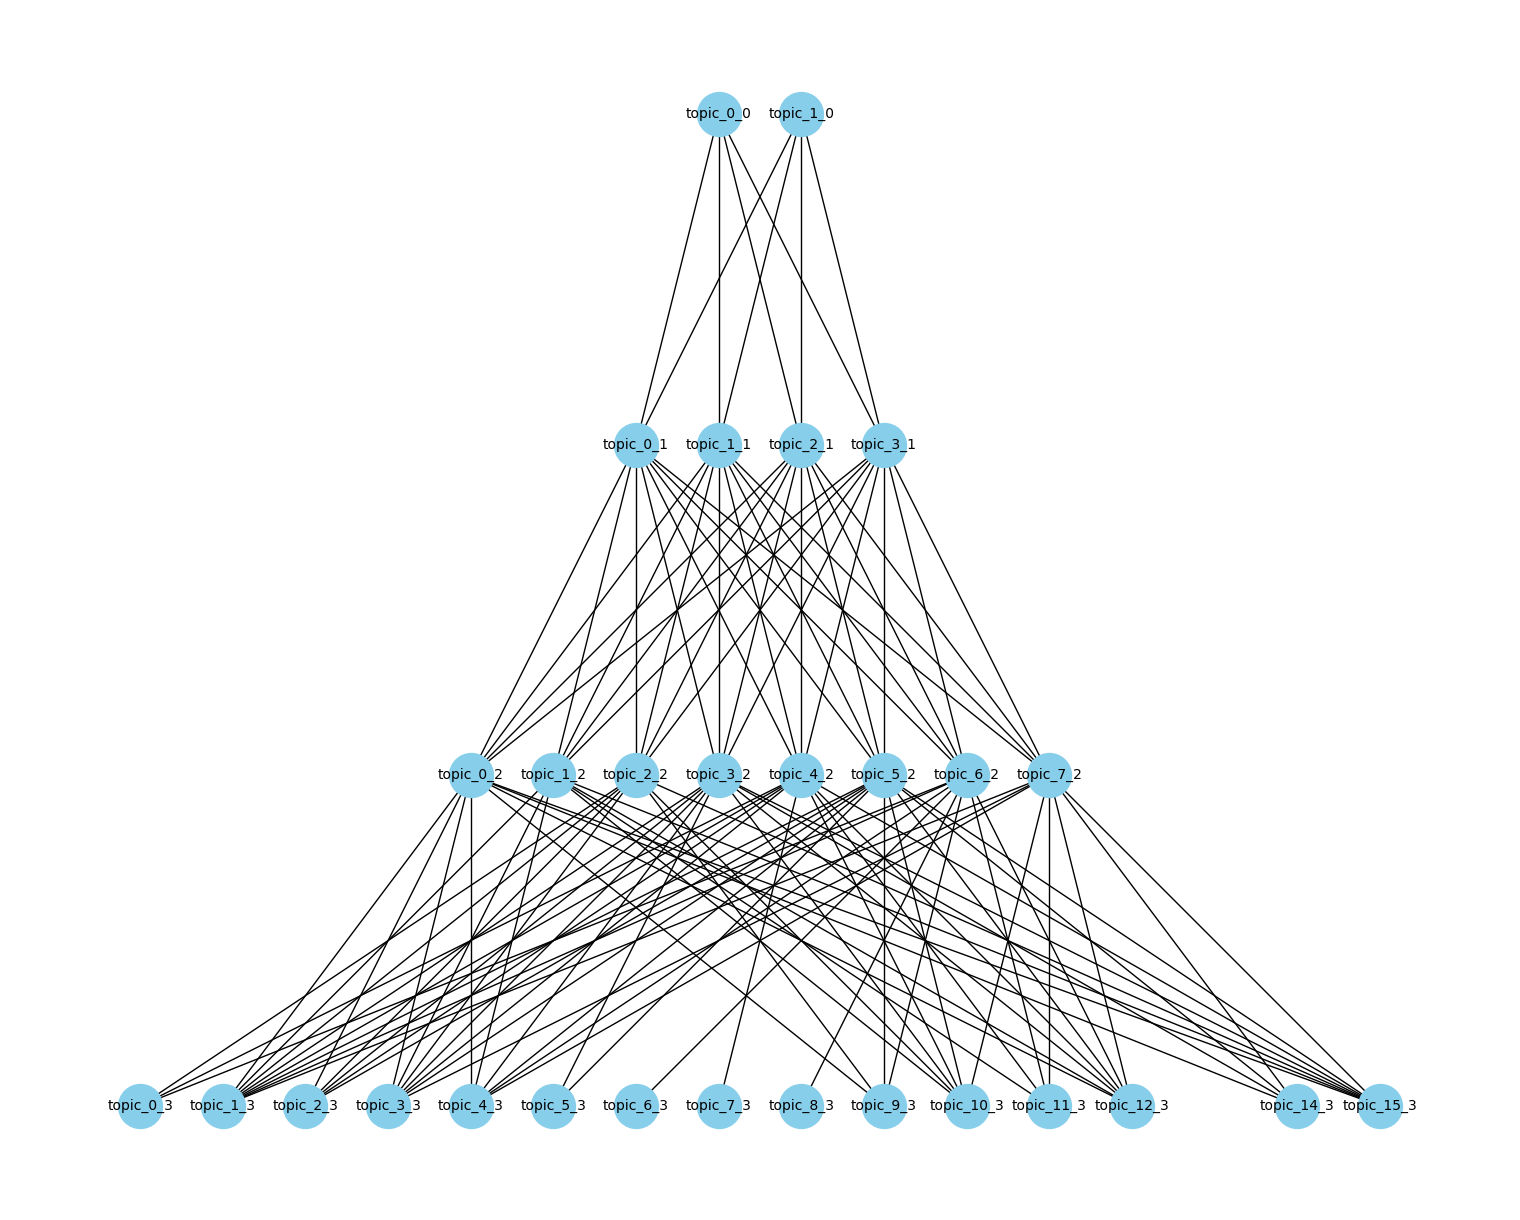

In [35]:
# Example usage
plot_hierarchical_connections(matrix_list, threshold=0.05)